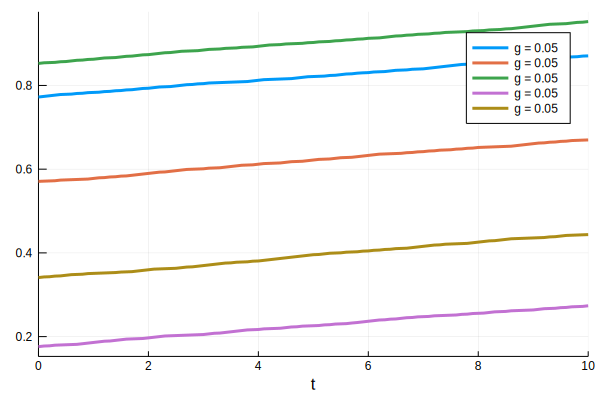

In [1]:
using DifferentialEquations, StochasticDiffEq, DiffEqJump, Plots, DiffEqNoiseProcess
function INPLACE_WHITE_NOISE_DIST_Trunc(g, rand_vec,W,dt,rng)
  DiffEqNoiseProcess.wiener_randn!(rng,rand_vec)
  rand_vec .*= sqrt(abs(dt))
    rand_vec .= clamp.(rand_vec, -g * abs(dt),  g * abs(dt)) 
end
TruncatedWienerProcess(g, t0,W0, Z0=nothing) = NoiseProcess(t0,W0,Z0,
    (rand_vec,W,dt,rng) -> INPLACE_WHITE_NOISE_DIST_Trunc(g, rand_vec,W,dt,rng),nothing)

function μ_SDE(u,p,t)
    p.μ
end

function σ_SDE(u,p,t)
    p.σ
end 

p = (μ = 0.01, σ = 0.1, N = 5, g = 0.05) 
T = 10.0
x_iv = rand(p.N)
w = TruncatedWienerProcess(p.g, 0.0, zeros(p.N), zeros(p.N))
prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p, noise = w)
sol = solve(prob, EM(), dt= 0.1)
plot(sol, label = "g = 0.05")

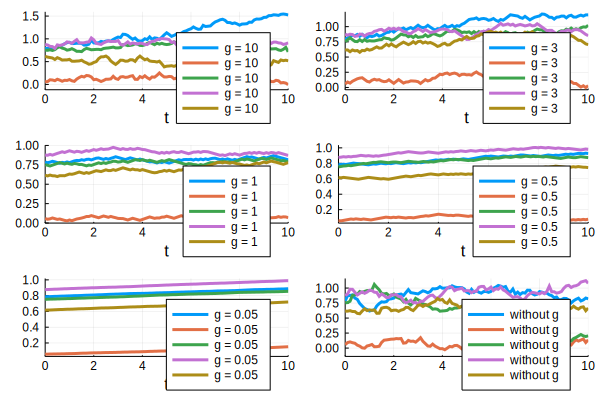

In [2]:
#comparing with different values of g
p = (μ = 0.01, σ = 0.1, N = 5) # if all constant
T = 10.0  # maximum time length
x_iv = rand(p.N)  # just draws from the inital condition
prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p)
sol = solve(prob, EM(), dt= 0.1)#solve(prob, SRIW1(), adaptive=false, dt = 0.1)####
plot_normal = plot(sol, label = "without g")
####-----
p_10 = (μ = 0.01, σ = 0.1, N = 5, g = 10) # if all constant
w_10 = TruncatedWienerProcess(p_10.g, 0.0,zeros(p_10.N),zeros(p_10.N))
prob_10 = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p_10, noise = w_10)
sol_10 = solve(prob_10, EM(), dt= 0.1)
plot_10 = plot(sol_10, label = "g = 10")
####-----
p_3 = (μ = 0.01, σ = 0.1, N = 5, g = 3) # if all constant
w_3 = TruncatedWienerProcess(p_3.g, 0.0,zeros(p_3.N),zeros(p_3.N))
prob_3 = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p_3, noise = w_3)
sol_3 = solve(prob_3, EM(), dt= 0.1)
plot_3 = plot(sol_3, label = "g = 3")
####-----
p_1 = (μ = 0.01, σ = 0.1, N = 5, g = 1) # if all constant
w_1 = TruncatedWienerProcess(p_1.g, 0.0,zeros(p_1.N),zeros(p_1.N))
prob_1 = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p_1, noise = w_1)
sol_1 = solve(prob_1, EM(), dt= 0.1)
plot_1 = plot(sol_1, label = "g = 1")
####-----
p_05 = (μ = 0.01, σ = 0.1, N = 5, g = 0.5) # if all constant
w_05 = TruncatedWienerProcess(p_05.g, 0.0,zeros(p_05.N),zeros(p_05.N))
prob_05 = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p_05, noise = w_05)
sol_05 = solve(prob_05, EM(), dt= 0.1)
plot_05 = plot(sol_05, label = "g = 0.5")
####-----
p_005 = (μ = 0.01, σ = 0.1, N = 5, g = 0.05) # if all constant
w_005 = TruncatedWienerProcess(p_005.g, 0.0,zeros(p_005.N),zeros(p_005.N))
prob_005 = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p_005, noise = w_005)
sol_005 = solve(prob_005, EM(), dt= 0.1)
plot_005 = plot(sol_005, label = "g = 0.05")
####-----
plot(plot_10, plot_3, plot_1, plot_05, plot_005, plot_normal, layout = (3, 2), legend = true )

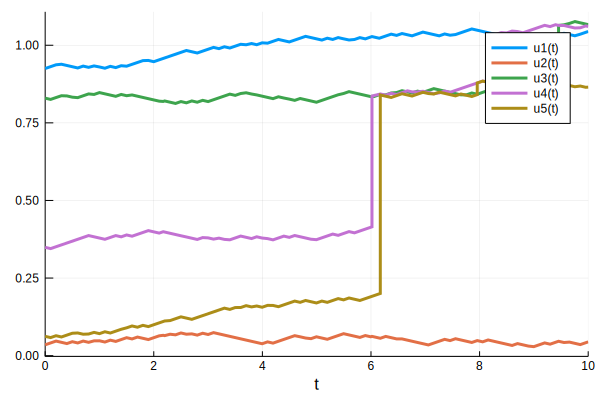

In [6]:
#with jumps g = 0.5
struct AffectIndex{F1, F2}
affect_index!::F1
index::F2
end
function (p::AffectIndex)(integrator)
return p.affect_index!(integrator, p.index)
end

p = (μ = 0.01, σ = 0.1, N = 5, g = 0.5) 
T = 10.0
x_iv = rand(p.N)
w = TruncatedWienerProcess(p.g, 0.0, zeros(p.N), zeros(p.N))
prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p, noise = w)


rate(u,p,t) = 0.2
affect_index!(integrator, index) = (integrator.u[index] =
    max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]) )
jumps = [ConstantRateJump(rate,AffectIndex(affect_index!, i)) for i in 1:p.N]
jump_prob = JumpProblem(prob,DirectFW(),JumpSet((), jumps, nothing, nothing))
sol = solve(jump_prob, EM(), dt= 0.1);#sol = solve(jump_prob, SRIW1());
plot(sol)